Records generated using ml.m5.4xlarge

In [1]:
import numpy as np
import pandas as pd
import scipy
import time
import ujson as json
import boto3
import s3fs
from multiprocessing import Process, Manager
from multiprocessing.pool import ThreadPool, Pool

LOW_PEACE = set(['Afghanistan', 'Congo', 'Guinea',
             'India', 'Iran', 'Kenya', 'Nigeria',
             'Sri Lanka', 'Uganda', 'Zimbabwe'])
HIGH_PEACE = set(['Austria', 'Australia', 'Belgium', 
             'Czech Republic', 'Denmark', 'Finland',
             'Netherlands', 'New Zealand', 'Norway', 'Sweden'])

In [2]:
bucket_name = 'lndata-columbia'
output_bucket_name = 'compressed-data-sample'

_HP = 'peaceClassify/data/highPeace'
_LP = 'peaceClassify/data/lowPeace'

client = boto3.client('s3')
paginator = client.get_paginator('list_objects_v2')

In [3]:
HP_page_iterator = paginator.paginate(Bucket=bucket_name, Prefix=_HP,PaginationConfig={'MaxItems':int(1e6)})
LP_page_iterator = paginator.paginate(Bucket=bucket_name, Prefix=_LP,PaginationConfig={'MaxItems':int(1e6)})

def file_generator(iterator):
    for page in iterator:
        for file in page['Contents']:
            yield file['Key']

In [9]:
# Test how many threads to use
from collections import Counter
from tqdm import tqdm

def count_article(filepath,counter):
    file_obj = s3_client.get_object(Bucket=bucket_name, Key=filepath)
    file_data = file_obj['Body'].read().decode('utf-8')
    io_data = io.StringIO(file_data).readlines()
    json_data = list(map(ujson.loads, io_data))
    counter[json_data[0]['source']['location']['country']] += 1
    
d = {}

for num_threads in range(8,41,8):
    time_start=time.time()
    for i in range(5):
        pool = ThreadPool(num_threads)
        c = Counter()
        for filepath in tqdm(file_generator(LP_page_iterator)):
            pool.apply_async(count_article, args=(filepath,c))
        pool.close()
        pool.join()
    time_end=time.time()
    d[num_threads] = (time_end-time_start)/5
print(d)

1000it [00:00, 3531.19it/s]
1000it [00:00, 4612.05it/s]
1000it [00:00, 4667.06it/s]
1000it [00:00, 3913.24it/s]
1000it [00:00, 4703.44it/s]
1000it [00:00, 4361.07it/s]
1000it [00:00, 4788.01it/s]
1000it [00:00, 3411.24it/s]
1000it [00:00, 4572.47it/s]
1000it [00:00, 5134.52it/s]
1000it [00:00, 5273.24it/s]
1000it [00:00, 5116.15it/s]
1000it [00:00, 3909.07it/s]
1000it [00:00, 5282.11it/s]
1000it [00:00, 4757.05it/s]
1000it [00:00, 4833.78it/s]
1000it [00:00, 3832.77it/s]
1000it [00:00, 4777.96it/s]
1000it [00:00, 5087.85it/s]
1000it [00:00, 3741.37it/s]
1000it [00:00, 5434.83it/s]
1000it [00:00, 4892.42it/s]
1000it [00:00, 5310.99it/s]
1000it [00:00, 5255.48it/s]
1000it [00:00, 4476.23it/s]

{8: 0.3135242462158203, 16: 0.3167637825012207, 24: 0.2545583724975586, 32: 0.3159449577331543, 40: 0.27922773361206055}


## Loading High Peace Data

In [11]:
time_start=time.time()

pool = ThreadPool(24)
manager = Manager()
data_hp = manager.list()
        
def runcommand(filepath, data):
    file_data = client.get_object(Bucket=bucket_name, Key=filepath)['Body'].read().decode('utf-8')
    json_data = json.loads(file_data)
    data.append((json_data['title'], 
                 json_data['content'],
                 json_data['wordCount'],
                 json_data['source']['location']['country']))
    
    
for filepath in file_generator(HP_page_iterator):
    result = pool.apply_async(runcommand, args=(filepath, data_hp))
        
result.get()
pool.close()
pool.join()

time_end = time.time()
print(f'Loading Time: {time_end-time_start} seconds')

Loading Time: 2416.73894739151 seconds


In [33]:
hp_df_list = [pd.DataFrame(data_hp[int(1e5)*i:int(1e5)*(i+1)], columns=['title', 'content', 'wordCount' ,'country']) for i in range(10)]
hp_df = pd.concat(hp_df_list, ignore_index=True)
hp_df.wordCount = hp_df.wordCount.map(int)
hp_df

,title,content,wordCount,country
0,MONTHLY SECTOR REPORT: S&P/ASX EMERGING COMPAN...,AUSTRALIAN MONTHLY INDEX REPORT\n\nThe S&P/ASX...,2405,Australia
1,PAPRIKA CLUB RESTAURANT,THE Paprika Club Restaurant offers freshly pre...,120,Australia
2,Bone implants to be made from 3D printed salt,ABSTRACT\n\n\n\nResearchers have developed a n...,545,Australia
3,"Yes, you're entitled to a free portrait of the...",It's a truth universally acknowledged that a h...,598,Australia
4,Why is Hemsworth wearing nail polish?,If you thought nail polish was only for women ...,729,Australia
...,...,...,...,...
999995,Murder sentence cannot heal family's heartache,The man who murdered 90-year-old Springbank gr...,621,Australia
999996,Residents' satisfaction with Shellharbour coun...,Shellharbour citizens' satisfaction with their...,313,Australia
999997,Weekly: Macmahon Holdings climbs 4.9% on weak ...,AUSTRALIAN WEEKLY STOCK REPORT\n\nMacmahon Hol...,3108,Australia
999998,Stock Weekly: Valoe (VALOE:6.22c) in bottom 1%...,FINNISH WEEKLY STOCK REPORT\n\nValoe Oyj (HEL:...,17401,Finland


In [34]:
hp_df.to_csv('s3://compressed-data-sample/compressed1m_hp.csv', index=False)

In [47]:
# Check if export correctly
start_time = time.time()
hp_df_check = pd.read_csv('s3://compressed-data-sample/compressed1m_hp.csv', 
                          dtype={"wordCount": 'int16', "country":'category'})
end_time = time.time()
print(f'Loading Time: {end_time-start_time} seconds')
hp_df_check

Loading Time: 275.4696309566498 seconds


,title,content,wordCount,country
0,MONTHLY SECTOR REPORT: S&P/ASX EMERGING COMPAN...,AUSTRALIAN MONTHLY INDEX REPORT\n\nThe S&P/ASX...,2405,Australia
1,PAPRIKA CLUB RESTAURANT,THE Paprika Club Restaurant offers freshly pre...,120,Australia
2,Bone implants to be made from 3D printed salt,ABSTRACT\n\n\n\nResearchers have developed a n...,545,Australia
3,"Yes, you're entitled to a free portrait of the...",It's a truth universally acknowledged that a h...,598,Australia
4,Why is Hemsworth wearing nail polish?,If you thought nail polish was only for women ...,729,Australia
...,...,...,...,...
999995,Murder sentence cannot heal family's heartache,The man who murdered 90-year-old Springbank gr...,621,Australia
999996,Residents' satisfaction with Shellharbour coun...,Shellharbour citizens' satisfaction with their...,313,Australia
999997,Weekly: Macmahon Holdings climbs 4.9% on weak ...,AUSTRALIAN WEEKLY STOCK REPORT\n\nMacmahon Hol...,3108,Australia
999998,Stock Weekly: Valoe (VALOE:6.22c) in bottom 1%...,FINNISH WEEKLY STOCK REPORT\n\nValoe Oyj (HEL:...,17401,Finland


In [48]:
# free space
del hp_df_check

## Loading Low Peace Data

In [49]:
time_start = time.time()

pool = ThreadPool(24)
manager = Manager()
data_lp = manager.list()
    
for filepath in file_generator(LP_page_iterator):
    result = pool.apply_async(runcommand, args=(filepath, data_lp))
        
result.get()
pool.close()
pool.join()

time_end = time.time()
print(f'Loading Time: {time_end-time_start} seconds')

Loading Time: 2441.7172915935516 seconds


In [50]:
lp_df_list = [pd.DataFrame(data_lp[int(1e5)*i:int(1e5)*(i+1)], 
                           columns=['title', 'content', 'wordCount' ,'country']) for i in range(10)]
lp_df = pd.concat(lp_df_list, ignore_index=True)
lp_df.wordCount = lp_df.wordCount.map(int)
lp_df

,title,content,wordCount,country
0,"Atlas Cycles (Haryana) keeps sliding, down 10....",INDIAN DAILY STOCK REPORT\n\nAtlas Cycles (Har...,1555,India
1,Varun Dhawan shares quirky boomerang to wish S...,"Mumbai (Maharashtra) [India], August 12 (ANI):...",177,India
2,Traffic cops launch Road Courtesy campaign,Vadodara: After conducting an intense drive fo...,308,India
3,United States Courts Opinions: UNITED STATES D...,Washington: UNITED STATES DISTRICT COURT NORTH...,1993,India
4,OSCE Secretary General sympathizes with Iran q...,Tehran: The official news agency of Iran (IRNA...,259,Iran
...,...,...,...,...
999995,"Intel Awarded Patent for Systems, Methods and ...",FULL TEXT\n\n\n\nPublication Name: Software Pa...,241,India
999996,Morning Alert: Williamson Magor & Co keeps ris...,INDIAN INTRA-DAY STOCK REPORT\n\nWilliamson Ma...,680,India
999997,"LJUBLJANSKE MLEKARNE, mlekarska industrija, d....","Slovenia, Nov. 14 -- Slovenia based LJUBLJANSK...",68,India
999998,STEEL AUTHORITY OF INDIA LIMITED (SAIL) Provid...,"India ,April 10 -- Tender No. CCNW/PR11300076...",51,India


In [51]:
lp_df.to_csv('s3://compressed-data-sample/compressed1m_lp.csv', index=False)

In [53]:
# Check if export correctly
start_time = time.time()
lp_df_check = pd.read_csv('s3://compressed-data-sample/compressed1m_lp.csv', 
                          dtype={"wordCount": 'int16', "country":'category'})
end_time = time.time()
print(f'Loading Time: {end_time - start_time} seconds')
lp_df_check

Loading Time: 131.2922923564911 seconds


,title,content,wordCount,country
0,"Atlas Cycles (Haryana) keeps sliding, down 10....",INDIAN DAILY STOCK REPORT\n\nAtlas Cycles (Har...,1555,India
1,Varun Dhawan shares quirky boomerang to wish S...,"Mumbai (Maharashtra) [India], August 12 (ANI):...",177,India
2,Traffic cops launch Road Courtesy campaign,Vadodara: After conducting an intense drive fo...,308,India
3,United States Courts Opinions: UNITED STATES D...,Washington: UNITED STATES DISTRICT COURT NORTH...,1993,India
4,OSCE Secretary General sympathizes with Iran q...,Tehran: The official news agency of Iran (IRNA...,259,Iran
...,...,...,...,...
999995,"Intel Awarded Patent for Systems, Methods and ...",FULL TEXT\n\n\n\nPublication Name: Software Pa...,241,India
999996,Morning Alert: Williamson Magor & Co keeps ris...,INDIAN INTRA-DAY STOCK REPORT\n\nWilliamson Ma...,680,India
999997,"LJUBLJANSKE MLEKARNE, mlekarska industrija, d....","Slovenia, Nov. 14 -- Slovenia based LJUBLJANSK...",68,India
999998,STEEL AUTHORITY OF INDIA LIMITED (SAIL) Provid...,"India ,April 10 -- Tender No. CCNW/PR11300076...",51,India


In [55]:
# free space
del lp_df_check

## View 1M sample Stats in each group

In [61]:
import scipy

def get_round_ci(sample, alpha=0.95):
    lower_bound, upper_bound = scipy.stats.t.interval(alpha, 
                                                      len(sample)-1,
                                                      np.mean(sample),
                                                      scipy.stats.sem(sample))
    return round(lower_bound, 4), round(upper_bound, 4)

lp_stats = lp_df.groupby('country').agg(sample_perc=('title', 'count'),
                                        avg_wordCount=('wordCount','mean'),
                                        wordCount_CI_95=('wordCount', lambda x: get_round_ci(x))
                                     )
# Final stats 
lp_stats.sample_perc = lp_stats.sample_perc.transform(lambda x: 100 * x / x.sum())
lp_stats

,sample_perc,avg_wordCount,wordCount_CI_95
country,,,
Afghanistan,0.2328,221.809708,"(213.6184, 230.001)"
Congo,0.4985,489.747041,"(477.5319, 501.9622)"
Guinea,0.0001,3121.000000,"(nan, nan)"
India,91.7565,422.663411,"(421.0335, 424.2933)"
Iran,2.3680,484.964443,"(479.5853, 490.3436)"
Kenya,0.5157,607.522397,"(594.3597, 620.6851)"
Nigeria,2.7022,579.226482,"(571.1824, 587.2705)"
Sri Lanka,1.3659,831.227542,"(810.2969, 852.1582)"
Uganda,0.2902,575.023777,"(560.7757, 589.2719)"


In [62]:
hp_stats = hp_df.groupby('country').agg(sample_perc=('title', 'count'),
                                        avg_wordCount=('wordCount','mean'),
                                        wordCount_CI_95=('wordCount', lambda x: get_round_ci(x))
                                     )
# Final stats 
hp_stats.sample_perc = hp_stats.sample_perc.transform(lambda x: 100 * x / x.sum())
hp_stats

,sample_perc,avg_wordCount,wordCount_CI_95
country,,,
Australia,76.0521,884.916874,"(882.2838, 887.55)"
Austria,0.4210,1240.742993,"(1200.2169, 1281.2691)"
Belgium,5.3665,703.747545,"(683.1177, 724.3774)"
Czech Republic,0.5935,415.039596,"(402.2787, 427.8005)"
Denmark,1.3845,1281.044854,"(1252.5792, 1309.5105)"
Finland,1.0927,1807.282694,"(1767.3396, 1847.2258)"
Netherlands,0.8204,1566.497075,"(1530.0766, 1602.9176)"
New Zealand,9.0610,526.680709,"(522.3605, 531.0009)"
Norway,1.2701,1851.772459,"(1815.7198, 1887.8251)"


## View Avg. Article Length Per Country

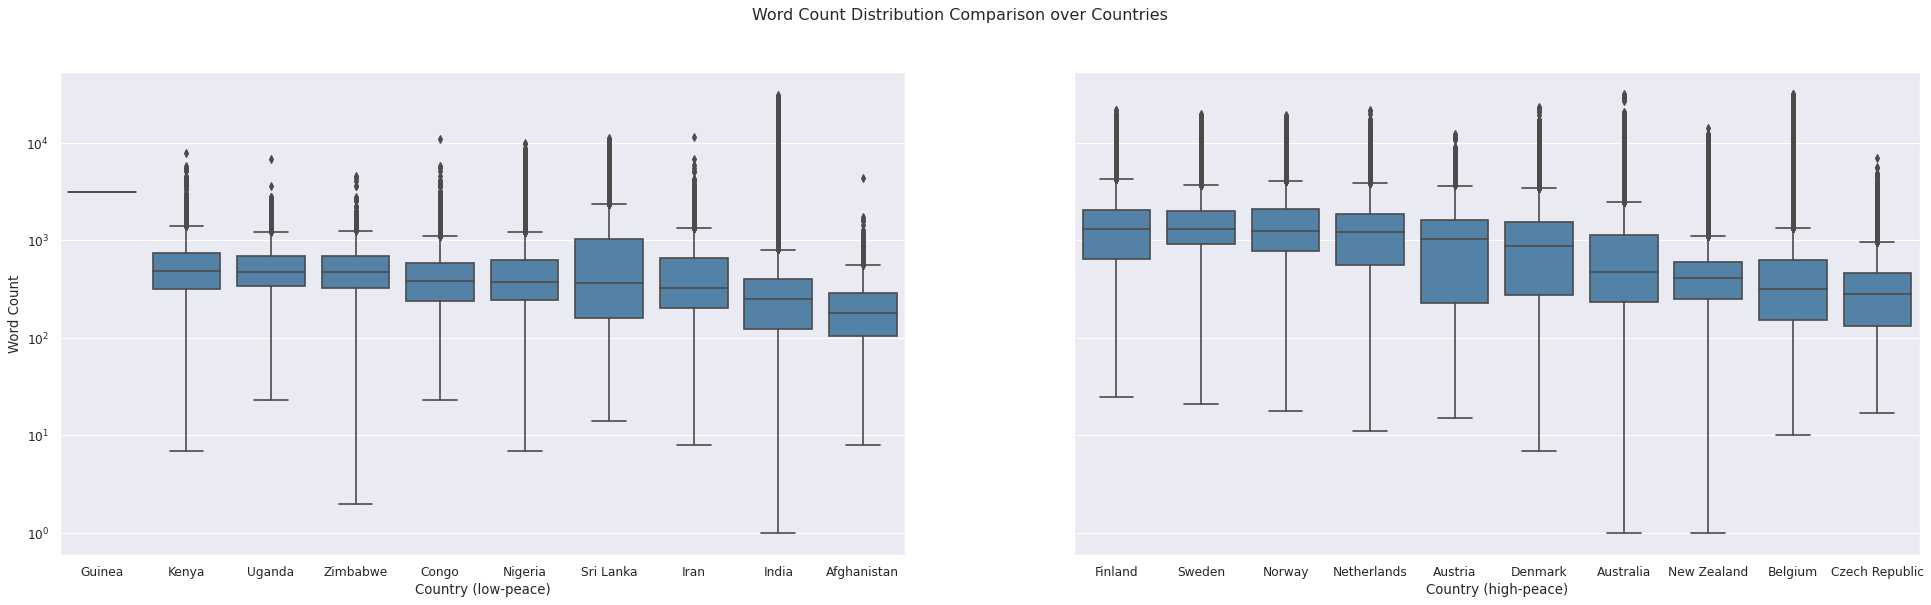

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(30,8), ncols=2, sharey=True, dpi=80)

sorted_index_lp = lp_df.groupby('country').agg({'wordCount': 'median'}).sort_values('wordCount', ascending=False).index
sorted_index_hp = hp_df.groupby('country').agg({'wordCount': 'median'}).sort_values('wordCount', ascending=False).index

sns.boxplot(x='country', y='wordCount', data=lp_df, color='steelblue', ax=ax[0], order=sorted_index_lp)
sns.boxplot(x='country', y='wordCount', data=hp_df, color='steelblue', ax=ax[1], order=sorted_index_hp)

ax[0].set(xlabel='Country (low-peace)', ylabel='Word Count')
ax[0].set_yscale('log')

ax[1].set(xlabel='Country (high-peace)', ylabel = '')
   
fig.suptitle('Word Count Distribution Comparison over Countries')
plt.show()

## Plot the iterative convergence plot

In [65]:
group_data = pd.concat([pd.concat([lp_df[:10**i], hp_df[:10**i]]) for i in range(3, 7)], ignore_index=True)
group_data['peaceful'] = group_data.country.map(lambda x: x in HIGH_PEACE)
group_data['group'] = ['1K'] * 2 * (10**3) + ['10K'] * 2* (10**4) + ['100K'] * 2 * (10**5) + ['1M'] * 2 * (10**6)

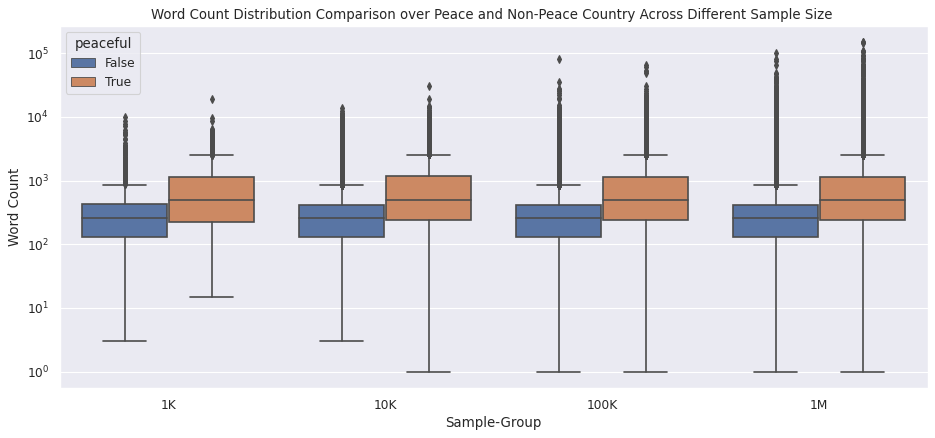

In [66]:
fig, ax = plt.subplots(figsize=(14,6), sharex=True, sharey=True,dpi=80)

sns.boxplot(x='group', y='wordCount', hue='peaceful', hue_order=[False, True],
            data=group_data, ax=ax)
ax.set_yscale('log')
ax.set(xlabel='Sample-Group', ylabel='Word Count', 
       title='Word Count Distribution Comparison over Peace and Non-Peace Country Across Different Sample Size ')

plt.show()

In [67]:
group_dict = {'1K':0, '10K':1, '100K':2, '1M':3}
group_data.groupby(['group', 'peaceful']).describe().sort_values('group', key=lambda x: x.map(group_dict))

wordCount                                                \
                    count        mean          std   min     25%    50%   
group peaceful                                                            
1K    False        1000.0  480.064000   839.020144   3.0  130.75  259.0   
      True         1000.0  884.981000  1199.921103  15.0  224.75  494.5   
10K   False       10000.0  436.083400   750.234108   3.0  128.00  257.0   
      True        10000.0  918.899500  1249.580898   1.0  239.00  497.0   
100K  False      100000.0  434.750620   807.295570   1.0  131.00  258.0   
      True       100000.0  904.128400  1271.521732   1.0  238.00  495.0   
1M    False     1000000.0  435.602821   791.469142   1.0  131.00  259.0   
      True      1000000.0  906.523503  1315.915010   1.0  238.00  493.0   

                                   
                    75%       max  
group peaceful                     
1K    False      425.25    9797.0  
      True      1130.00   18908.0  
10K   False      413.00   13869.0  
      True      1170.00   30324.0  
100K  False      415.00   82669.0  
      True      1146.00   64822.0  
1M    False      416.00  101327.0  
      True      1146.00  149973.0

### Compare between High Peace and Low Peace
**Hypothesis 1**: High-peace countries tend to have longer English articles than low-peace countries
- H0: Distribution of article length from high-peace country = Distribution of LP article length from low-peace country
- H1 Distribution of article length from high-peace country > Distribution of LP article length from low-peace country

In [68]:
scipy.stats.wilcoxon(hp_df.wordCount, y=lp_df.wordCount, 
                     zero_method='wilcox', correction=False, alternative='greater', mode='auto')

WilcoxonResult(statistic=374641694823.0, pvalue=0.0)

**Conclusion**: The alternative hypothesis is true. Articles from high-peace countries are significantly longer than articles from low-peace countries.